# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Introdução

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado offline**.


## Sobre os dados


Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). Todos os dados são de pacientes mulheres de pelo menos 21 anos de idade. As *features* são:

* Pregnancies: Número de eventos de gravidez; 
* Glucose: Concentração de glicose plasmática;
* BloodPressure: Pressão sanguínea diastólica ($mmHg$);
* SkinThickness: Grossura da dobra da pele do tríceps ($mm$);
* Insulin: Insulina sérica ($\mu U/mL$);
* BMI: *Body mass index*, Peso em $kg$ / (altura em $m$)$^2$;
* DiabetesPedigreeFunction: mede a possibilidade de diabetes dado o histórico familiar;
* Age: Idade (anos);
* Outcome: Target, 0 para não-diabético, 1 para diabético.



## Problema de negócio e avaliação do modelo

O custo de exame e de prevenção são significativamente menores que os custos de tratamento da diabetes. Além disso, a detecção precoce facilita o tratamento (https://www.previva.com.br/reduzir-custo-do-diabetes/).

A métrica que utilizaremos para avaliar o modelo será a **acurácia**. Compararemos nossos resultados com um modelo empírico baseado na concentração de glicose. 

Utilizaremos os seguintes dados fictícios para simular o gasto público: o custo de tratamento é de $R\$$ 200/paciente x mês, enquanto o custo de exame/prevenção é de $R\$$ 50,00 / paciente x mês.

## Importando e explorando os dados

In [149]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [150]:
data = pd.read_csv("data/diabetes.csv")

In [151]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [152]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [153]:
# Checando duplicados

data.duplicated().sum()

0

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Não que seja necessário nesse caso, mas podemos reduzir o uso de memória alterando os dtypes.

In [155]:
int_cols = list(data.select_dtypes('int64').columns) 
float_cols = list(data.select_dtypes('float64').columns)

for col in int_cols:
    data[col] = data[col].astype('int16')   # Não temos valores fora de [-32767, +32767]
    
for col in float_cols:
    data[col] = data[col].astype('float32') # 32bits é suficiente para precisão que temos

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   768 non-null    int16  
 2   BloodPressure             768 non-null    int16  
 3   SkinThickness             768 non-null    int16  
 4   Insulin                   768 non-null    int16  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 16.6 KB


Tivemos uma redução significativa de uso de memória.

In [157]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos ({100*data[col].eq(0).sum()/data.shape[0]:.1f} %) em {col}.")

111 valores nulos (14.5 %) em Pregnancies.
5 valores nulos (0.7 %) em Glucose.
35 valores nulos (4.6 %) em BloodPressure.
227 valores nulos (29.6 %) em SkinThickness.
374 valores nulos (48.7 %) em Insulin.
11 valores nulos (1.4 %) em BMI.
0 valores nulos (0.0 %) em DiabetesPedigreeFunction.
0 valores nulos (0.0 %) em Age.
500 valores nulos (65.1 %) em Outcome.


Valores nulos de `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` são na verdade dados faltantes (NaN). A coluna `Insulin` possui uma quantidade significativa de NaN.

Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [158]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.700001,0.140,22,0
182,1,0,74,20,23,27.700001,0.299,21,0
342,1,0,68,35,0,32.000000,0.389,22,0
349,5,0,80,32,0,41.000000,0.346,37,1
502,6,0,68,41,0,39.000000,0.727,41,1


In [159]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias nulas em `Glucose` e são relativamente homogêneas.

## Redifinindo dados faltantes e separação treino/teste

A partir de agora corrigiremos os valores nulos por NaN e reservaremos nosso dataset de teste para o final.

In [160]:
# Vamos substituir 0 por NaN

data_nan = data.copy()

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_nan[col] = data_nan[col].replace(0, np.nan)

data_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.599998,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.299999,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.099998,2.288,33,1


In [161]:
data_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), float64(4), int16(3)
memory usage: 34.6 KB


In [162]:
# Separação de features e targets
X = data_nan.drop('Outcome', axis=1)
y = data_nan['Outcome']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [163]:
# Checando número de instâncias no treino e no teste e proporções

print(f'Treino: {y_train.shape[0]}')
print(f'Teste: {y_test.shape[0]}')

Treino: 614
Teste: 154


In [164]:
# Dataset completo
y.value_counts()*100 / y.value_counts().sum()

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [165]:
# Treino
y_train.value_counts()*100 / y_train.value_counts().sum()

0    65.14658
1    34.85342
Name: Outcome, dtype: float64

In [166]:
# Teste
y_test.value_counts()*100 / y_test.value_counts().sum()

0    64.935065
1    35.064935
Name: Outcome, dtype: float64

In [167]:
y_test.value_counts()

0    100
1     54
Name: Outcome, dtype: int64

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

In [168]:
def plot_histgram_and_boxplot(data, feature):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    sns.histplot(data=data, x=feature, hue="Outcome")

    plt.subplot(1,2,2)
    sns.boxplot(data=data, x="Outcome", y=feature)
    
    plt.suptitle(feature)
    plt.show()

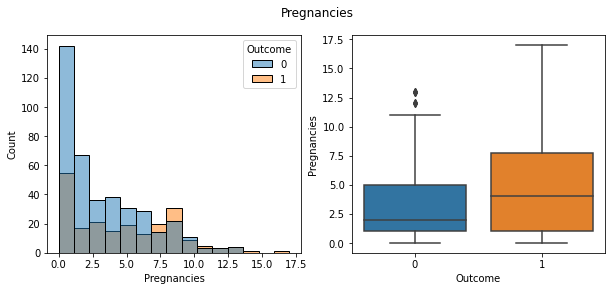

In [169]:
plot_histgram_and_boxplot(X_train.join(y_train), "Pregnancies")

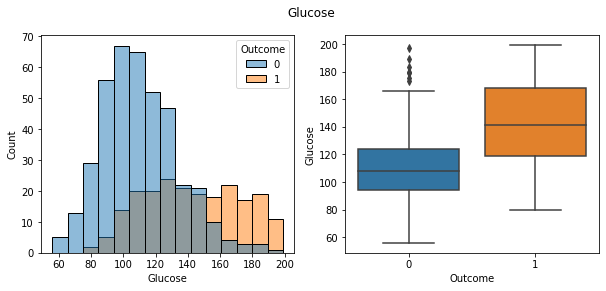

In [170]:
plot_histgram_and_boxplot(X_train.join(y_train), "Glucose")

In [171]:
# Algumas métricas de Glucose separadas por Outcome

X_train.join(y_train).loc[:, ['Outcome', 'Glucose']].groupby('Outcome').describe()

Glucose                                                         
          count        mean        std   min    25%    50%    75%    max
Outcome                                                                 
0         398.0  110.404523  23.507642  56.0   94.0  108.0  124.0  197.0
1         212.0  142.910377  29.707204  80.0  119.0  141.5  168.0  199.0

As médias são razoavelmente diferentes, mas os desvios são relativamentos próximos.

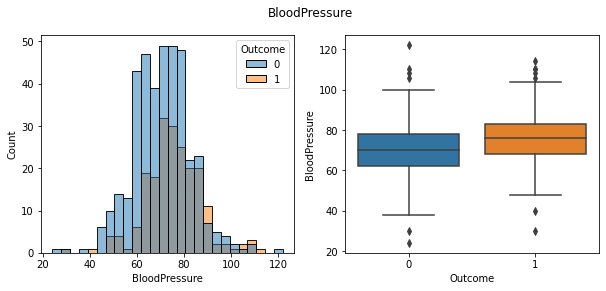

In [172]:
plot_histgram_and_boxplot(X_train.join(y_train), "BloodPressure")

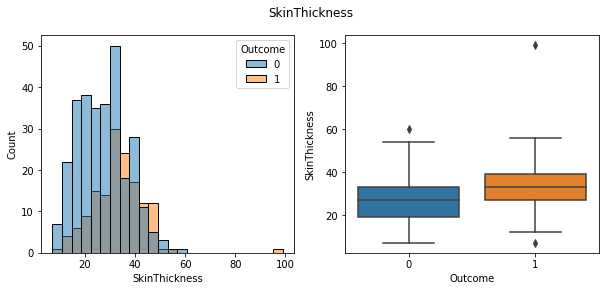

In [173]:
plot_histgram_and_boxplot(X_train.join(y_train), "SkinThickness")

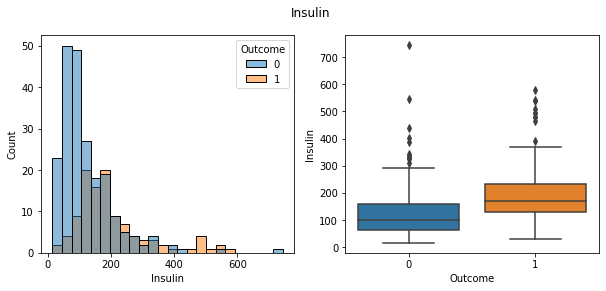

In [174]:
plot_histgram_and_boxplot(X_train.join(y_train), "Insulin")

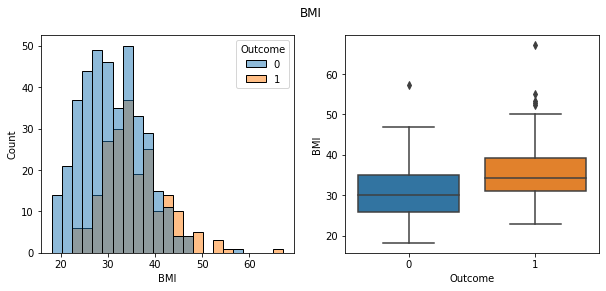

In [175]:
plot_histgram_and_boxplot(X_train.join(y_train), "BMI")

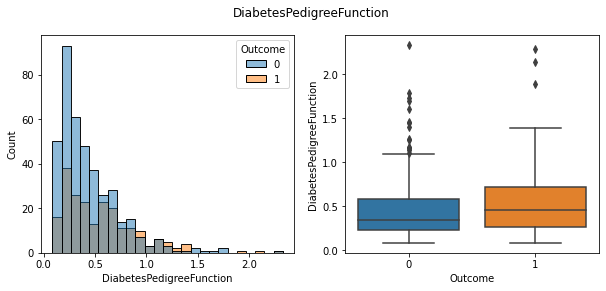

In [176]:
plot_histgram_and_boxplot(X_train.join(y_train), "DiabetesPedigreeFunction")

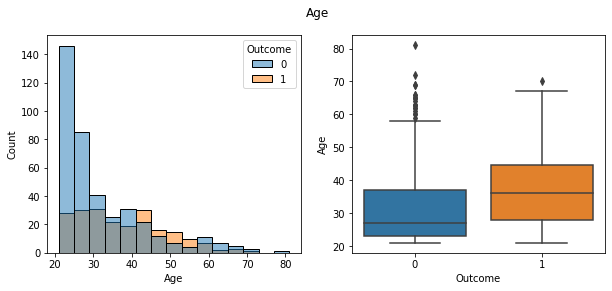

In [177]:
plot_histgram_and_boxplot(X_train.join(y_train), "Age")

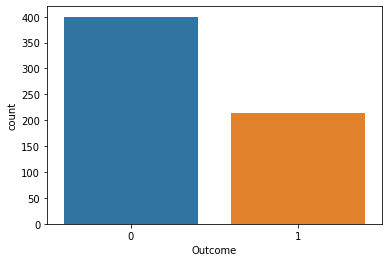

In [178]:
sns.countplot(data=X_train.join(y_train),  x='Outcome');

Outcome                     1.000000
Glucose                     0.514676
Insulin                     0.351211
BMI                         0.330770
SkinThickness               0.279891
Age                         0.240676
Pregnancies                 0.208173
BloodPressure               0.187674
DiabetesPedigreeFunction    0.165312
Name: Outcome, dtype: float64


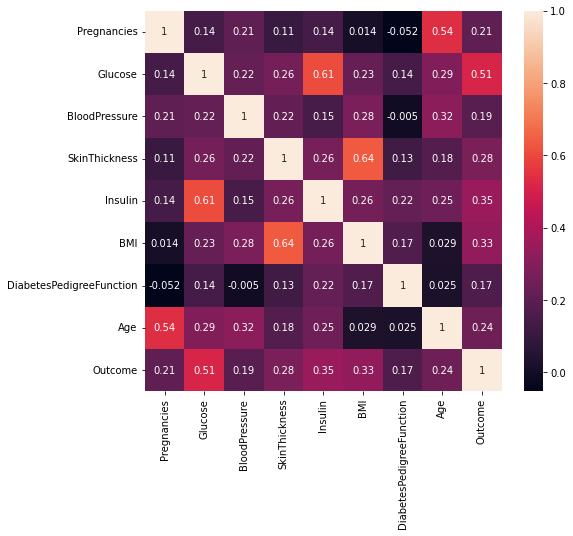

In [179]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))   

correlacao(X_train.join(y_train))

plt.figure(figsize=(8,7))
sns.heatmap(data=X_train.join(y_train).corr(), annot=True);

A partir da EDA podemos concluir que nossa *target* `Outcome` é suficientemente balanceada e é bem correlacionada com `Glucose`, `BMI`, `Age` e `Preganancies`. Entretanto, parece já existir uma dependência entre `Age` e `Preganancies`. Também parece haver algum grau de codepêndencia entre `SkinThickness`, `BMI` e `Insulin`.

## Modelo de referência

Nosso modelo heurístico é baseado no fato que a taxa de glicose deve ser o parâmetro mais importante para determinar se um paciente é diabético. Dito isto, vamos tentar achar um valor ideal de `Glucose` que nos dê o melhor resultado.

In [180]:
# Criar um X,y para modelo de referência, dropando os NaNs

filtro_nan = X_train['Glucose'].isna()
index_nan = X_train[filtro_nan].index.tolist()

X_train_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_train_heuristic = y_train.drop(index=index_nan)

In [181]:
# Treinando o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []
recall_list = []
precision_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0
    
for thr in glucose_thr:
    outcome_predict = X_train_heuristic["Glucose"].apply(test_glucose, thr=thr)
    
    accuracy = np.round(accuracy_score(y_train_heuristic, outcome_predict), 4)
    precision = np.round(precision_score(y_train_heuristic, outcome_predict), 4)
    recall = np.round(recall_score(y_train_heuristic, outcome_predict), 4)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

Utilizaremos o cruzamento entre precision e recall: ainda conservamos um bom recall, temos um alguma precisão e estamos um bom ponto de acurácia.

In [182]:
# Encontrando o ponto de acurácia máxima

accuracy_array = np.array(accuracy_list)
idx = accuracy_array.argmax()

train_recall = recall_list[idx]
train_precision = precision_list[idx]
train_accuracy = accuracy_list[idx]

thr_heuristic = glucose_thr[idx]

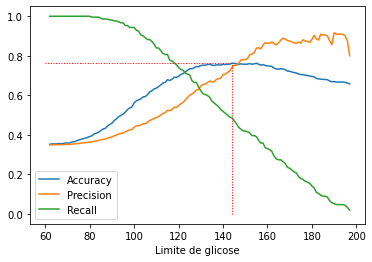

In [183]:
plt.plot(glucose_thr, accuracy_list, label='Accuracy')
plt.plot(glucose_thr, precision_list, label='Precision')
plt.plot(glucose_thr, recall_list, label='Recall')
plt.hlines(y=train_accuracy, xmin=60, xmax=thr_heuristic, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_heuristic, ymin=0.0, ymax=train_accuracy, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.legend()
plt.show()

In [184]:
# Print das métricas de treino

print("Métricas de treino:")
print(f"Acurácia: {train_accuracy}")
print(f"Precisão: {train_precision}")
print(f"Recall: {train_recall}")

Métricas de treino:
Acurácia: 0.7623
Precisão: 0.741
Recall: 0.4858


Finalmente, vamos avaliar o modelo com os dados de teste. Essas métricas serão uma das nossas referências para avaliar a performace no final.

In [185]:
# Removendo NaN do teste

filtro_nan = X_test['Glucose'].isna()
index_nan = X_test[filtro_nan].index.tolist()

X_test_heuristic = X_test[['Glucose']].drop(index=index_nan)
y_test_heuristic = y_test.drop(index=index_nan)

In [186]:
# Predict no dataset de teste

outcome_predict = X_test_heuristic["Glucose"].apply(test_glucose, thr=thr_heuristic)

accuracy = np.round(accuracy_score(y_test_heuristic, outcome_predict), 4)
precision = np.round(precision_score(y_test_heuristic, outcome_predict), 4)
recall = np.round(recall_score(y_test_heuristic, outcome_predict), 4)

print("Métricas de teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")

Métricas de teste:
Acurácia: 0.7059
Precisão: 0.6216
Recall: 0.4259


Ao final também iremos comparar a matriz de confusão:

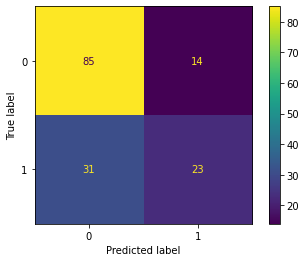

In [187]:
# Matriz de confusão para o modelo heurístico

cm_heuristic = confusion_matrix(y_test_heuristic, outcome_predict)
ConfusionMatrixDisplay(cm_heuristic).plot();

# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos o mínimo tratamento dos dados ou otimizações nos modelos no momento. Utilizaremos **validação cruzada** uma vez que temos poucas instâncias no dataset e reservaremos o dataset de teste para a avaliação final.

In [188]:
# Definindo uma função para avaliar os modelos com validação cruzada

def relatorio_cross_val(estimator, X_train, y_train):
    """Calcula acurácia, precisão e recall utilizando cross validation"""
    
    cv_accuracy_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="accuracy")
    cv_precision_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="precision")
    cv_recall_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="recall")
    
    cv_accuracy_mean_score = cv_accuracy_score.mean()
    cv_accuracy_std_score = cv_accuracy_score.std()
    
    cv_precision_mean_score = cv_precision_score.mean()
    cv_precision_std_score = cv_precision_score.std()
    
    cv_recall_mean_score = cv_recall_score.mean()
    cv_recall_std_score = cv_recall_score.std()
    
    print(f'Modelo: {estimator}')
    print(f"Acurácia média: {np.round(cv_accuracy_mean_score, 4)} (std={np.round(cv_accuracy_std_score, 4)})")
    print(f"Precisão média: {np.round(cv_precision_mean_score, 4)} (std={np.round(cv_precision_std_score, 4)})")
    print(f"Recall médio: {np.round(cv_recall_mean_score, 4)} (std={np.round(cv_recall_std_score, 4)})")

In [189]:
# Voltando os NaNs para zero

X_train_fillna = X_train.fillna(0)

Começaremos com uma *decision tree* para ganhar algum insight sobre os dados:

In [190]:
# Decision tree

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train_fillna, y_train)
relatorio_cross_val(tree_clf, X_train_fillna, y_train)

Modelo: DecisionTreeClassifier(max_depth=2, random_state=42)
Acurácia média: 0.7525 (std=0.0311)
Precisão média: 0.7967 (std=0.0641)
Recall médio: 0.3882 (std=0.0802)


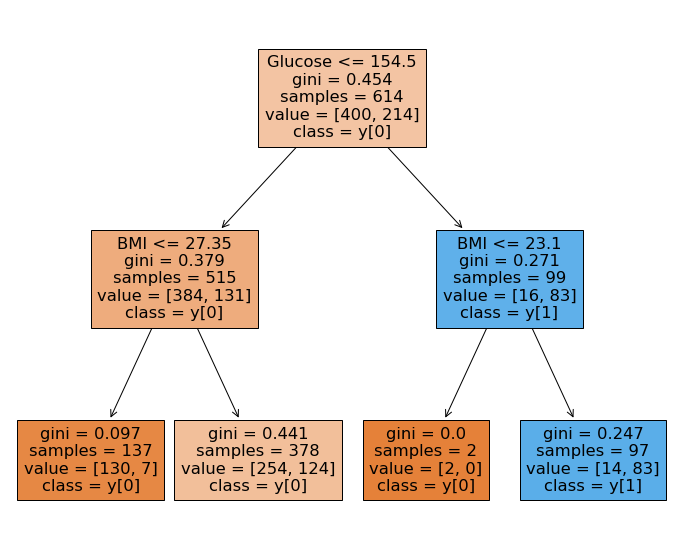

In [191]:
# Plotando árvore

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore simples, já temos uma acurácia média de 73,46%. Também confirmamos algumas expectativas: `Glucose`, `Age` e `BMI` são variáveis importantes nesse problema.

Também podemos treinar uma regressão logística, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [192]:
# Regressão logística

log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_fillna)

relatorio_cross_val(log_clf, X_train_sc, y_train)

Modelo: LogisticRegression()
Acurácia média: 0.7785 (std=0.0126)
Precisão média: 0.7442 (std=0.0473)
Recall médio: 0.5656 (std=0.0466)


In [193]:
# Regressão logística (balanced)

log_clf = LogisticRegression(class_weight='balanced')

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_fillna)

relatorio_cross_val(log_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7508 (std=0.0439)
Precisão média: 0.6343 (std=0.0724)
Recall médio: 0.7103 (std=0.0233)


In [194]:
# Random Forest
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_fillna, y_train)
relatorio_cross_val(forest_clf, X_train_fillna, y_train)

Modelo: RandomForestClassifier(random_state=42)
Acurácia média: 0.7655 (std=0.0336)
Precisão média: 0.6984 (std=0.0677)
Recall médio: 0.589 (std=0.0653)


A partir da floresta treinada podemos extrair a importância de cada feature.

In [195]:
feature_importance = pd.DataFrame(zip(X_train_fillna.columns, forest_clf.feature_importances_),
                                  columns=['feature', 'importance']).sort_values(by='importance', 
                                                                                 ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,Glucose,0.276009
1,BMI,0.159544
2,Age,0.127248
3,DiabetesPedigreeFunction,0.126731
4,BloodPressure,0.085606
5,Pregnancies,0.084456
6,Insulin,0.072409
7,SkinThickness,0.067997


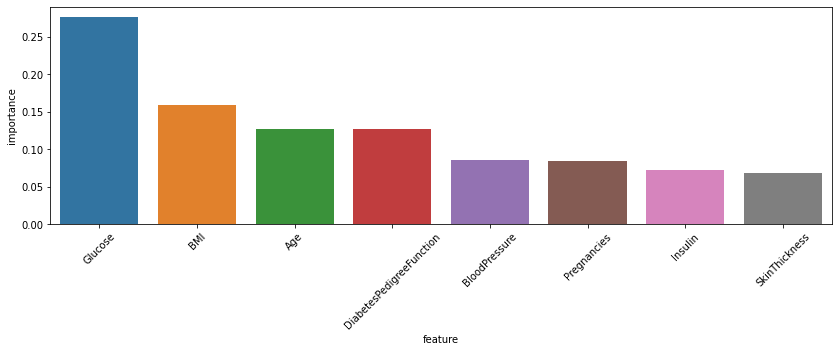

In [196]:
plt.figure(figsize=(14,4))
chart = sns.barplot(data=feature_importance, x='feature', y='importance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Confirmamos que `Glucose`, `BMI` e `Age` são variáveis importantes.

In [197]:
# Support Vector Machine

svc_clf = SVC(kernel='linear')
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: SVC(kernel='linear')
Acurácia média: 0.7753 (std=0.0185)
Precisão média: 0.73 (std=0.0446)
Recall médio: 0.5703 (std=0.0382)


In [198]:
# Support Vector Machine (balanceado)

svc_clf = SVC(kernel='linear', class_weight='balanced')
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7541 (std=0.0387)
Precisão média: 0.6439 (std=0.0632)
Recall médio: 0.6777 (std=0.0463)


Com esses modelos simples de ML já temos resultados significativamente melhores que o modelo heurístico. Usar pesos com o parâmetro `class_weight` reduz a acurácia mas melhora nosso recall, o que é interessante para o tipo de problema que estamos resolvendo.

# Tratamento dos dados

Podemos limpar um pouco os dados antes de tentar modelos ML mais elaborados. Nessa seção, trataremos os dados faltantes e os outliers.

In [199]:
# Modelos para avaliação

log_clf = LogisticRegression(class_weight='balanced')
forest_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
svc_clf = SVC(kernel='linear', class_weight='balanced')

In [200]:
# Avaliação sem tratamento (apenas scaling)

std_scaler = StandardScaler()
X_train_tr = std_scaler.fit_transform(X_train_fillna)

relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7508 (std=0.0439)
Precisão média: 0.6343 (std=0.0724)
Recall médio: 0.7103 (std=0.0233)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7638 (std=0.0333)
Precisão média: 0.7052 (std=0.0715)
Recall médio: 0.5654 (std=0.0596)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7541 (std=0.0387)
Precisão média: 0.6439 (std=0.0632)
Recall médio: 0.6777 (std=0.0463)


### Drop de features

In [201]:
# Criar estimador para drop de features

In [202]:
# Dropar Insulin e SkinThickness

### Lidando com dados faltantes

Vamos comparar o SimpleImputer (testando média e mediana) e o KNNImputer.

In [203]:
# Testando SimpleImputer (mean)

sim_imp = SimpleImputer(strategy='mean')
std_scaler = StandardScaler()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)


relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.759 (std=0.0277)
Precisão média: 0.6445 (std=0.0478)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7606 (std=0.0244)
Precisão média: 0.6912 (std=0.0462)
Recall médio: 0.5702 (std=0.0691)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7558 (std=0.0287)
Precisão média: 0.6456 (std=0.0469)
Recall médio: 0.6732 (std=0.0367)


In [204]:
# Testando SimpleImputer (median)

sim_imp = SimpleImputer(strategy='mean')
std_scaler = StandardScaler()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)


relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.759 (std=0.0277)
Precisão média: 0.6445 (std=0.0478)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7606 (std=0.0244)
Precisão média: 0.6912 (std=0.0462)
Recall médio: 0.5702 (std=0.0691)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7558 (std=0.0287)
Precisão média: 0.6456 (std=0.0469)
Recall médio: 0.6732 (std=0.0367)


In [205]:
# Testando KNNImputer

knn_imp = KNNImputer(n_neighbors=15)
std_scaler = StandardScaler()

treat_steps = [('imputer', knn_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7525 (std=0.0374)
Precisão média: 0.6351 (std=0.0595)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7703 (std=0.0239)
Precisão média: 0.7011 (std=0.0576)
Recall médio: 0.6029 (std=0.0408)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7606 (std=0.0276)
Precisão média: 0.6551 (std=0.0498)
Recall médio: 0.6731 (std=0.0311)


Vamos usar o tratamento do `SimpleImputer` com a média. Antes de prosseguir vamos analisar novamente os dados após o tratamento.

In [206]:
# Reconstruindo o dataframe

sim_imp = SimpleImputer(strategy='mean')

X_train_impute = pd.DataFrame(sim_imp.fit_transform(X_train), 
                              columns=X_train.columns, 
                              index=X_train.index)

X_train_impute.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,12.000000,43.00000,27.200001,0.580,24.0
711,5.0,126.0,78.0,27.000000,22.00000,29.600000,0.439,40.0
373,2.0,105.0,58.0,40.000000,94.00000,34.900002,0.225,25.0
46,1.0,146.0,56.0,29.059226,149.07716,29.700001,0.564,29.0
682,0.0,95.0,64.0,39.000000,105.00000,44.599998,0.366,22.0


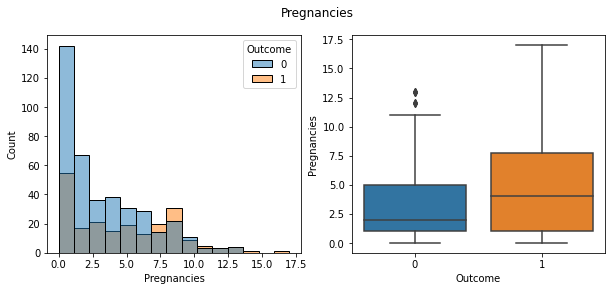

In [207]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Pregnancies")

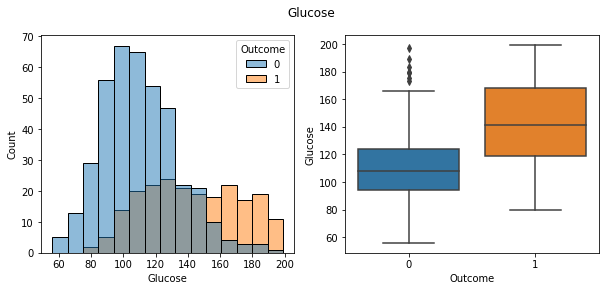

In [208]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Glucose")

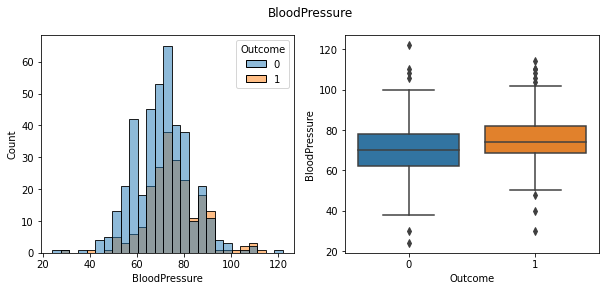

In [209]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BloodPressure")

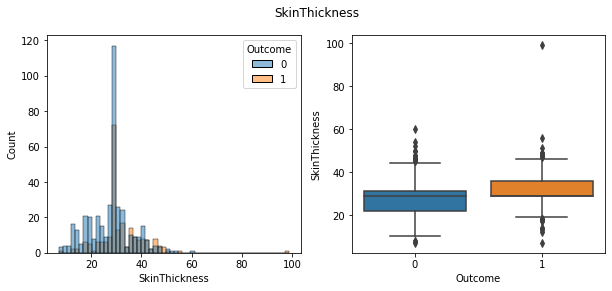

In [210]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "SkinThickness")

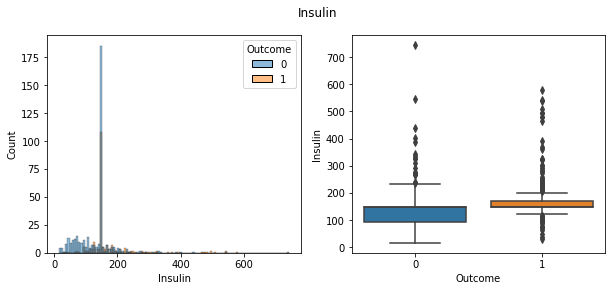

In [211]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Insulin")

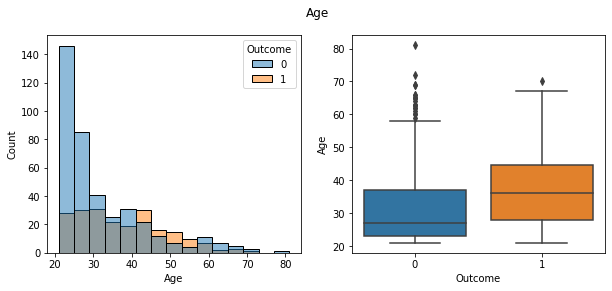

In [212]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Age")

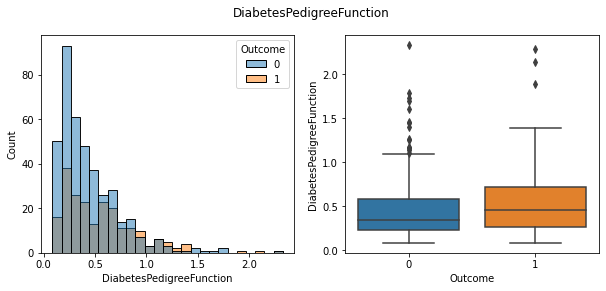

In [213]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "DiabetesPedigreeFunction")

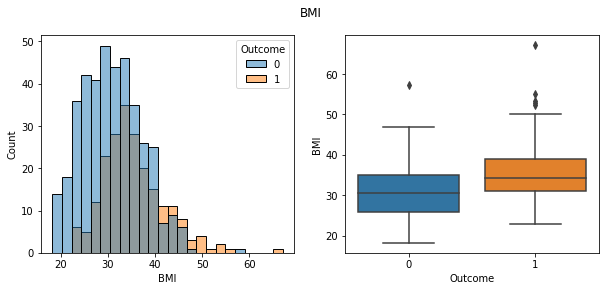

In [214]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BMI")

Vamos verificar novamente a matriz de correlação.

In [215]:
corr_matrix = X_train_impute.join(y_train).corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.512656
BMI                         0.328746
Insulin                     0.252974
Age                         0.240676
SkinThickness               0.234398
Pregnancies                 0.208173
BloodPressure               0.183494
DiabetesPedigreeFunction    0.165312
Name: Outcome, dtype: float64


 Nota-se que temos uma melhor correlação com o target.

### Tratando outliers

A distribuição da `DiabetesPedigreeFunction` parece muito inviesada. Aplicar um logaritmo torna ela mais normal:

In [216]:
X_train_log = X_train_impute.copy()

In [217]:
# X_train_log['LogDiabetesPedigreeFunction'] = np.log(X_train_log['DiabetesPedigreeFunction'])
# plot_dist_box(X_train_log.join(y_train), "LogDiabetesPedigreeFunction")

In [218]:
correlacao(X_train_log.join(y_train))

Outcome                     1.000000
Glucose                     0.512656
BMI                         0.328746
Insulin                     0.252974
Age                         0.240676
SkinThickness               0.234398
Pregnancies                 0.208173
BloodPressure               0.183494
DiabetesPedigreeFunction    0.165312
Name: Outcome, dtype: float64


A distribuição parece mais normais e as correlação melhorou.

In [219]:
drop = ["DiabetesPedigreeFunction"]
X_train_log = X_train_log.drop(drop, axis=1)
X_train_log.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
353,1.0,90.0,62.0,12.000000,43.00000,27.200001,24.0
711,5.0,126.0,78.0,27.000000,22.00000,29.600000,40.0
373,2.0,105.0,58.0,40.000000,94.00000,34.900002,25.0
46,1.0,146.0,56.0,29.059226,149.07716,29.700001,29.0
682,0.0,95.0,64.0,39.000000,105.00000,44.599998,22.0


In [220]:
std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_log)

relatorio_cross_val(log_clf, X_train_sc, y_train)
print()
relatorio_cross_val(forest_clf, X_train_sc, y_train)
print()
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7362 (std=0.0408)
Precisão média: 0.6132 (std=0.0685)
Recall médio: 0.7056 (std=0.0697)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.746 (std=0.0209)
Precisão média: 0.6652 (std=0.0423)
Recall médio: 0.5564 (std=0.0587)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7394 (std=0.0229)
Precisão média: 0.6242 (std=0.0519)
Recall médio: 0.6637 (std=0.0822)


Apesar das correlações melhorarem, nosso modelo teve uma performace pior. Vamos seguir sem esse tratamento.

### Binning

Vamos tentar agora agrupar dados para reduzir o ruído de alguma feature. Como discutido, fazer esse tratamento isso na `Age` talvez ajude nosso modelo. 

In [221]:
X_train_bins = X_train_impute.copy()
X_train_bins.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,12.000000,43.00000,27.200001,0.580,24.0
711,5.0,126.0,78.0,27.000000,22.00000,29.600000,0.439,40.0
373,2.0,105.0,58.0,40.000000,94.00000,34.900002,0.225,25.0
46,1.0,146.0,56.0,29.059226,149.07716,29.700001,0.564,29.0
682,0.0,95.0,64.0,39.000000,105.00000,44.599998,0.366,22.0


Usaremos `KBinsDiscretizer`:

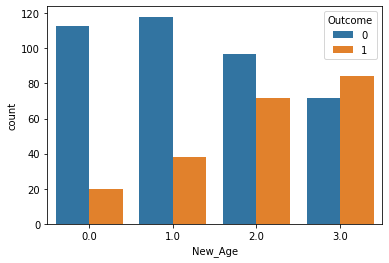

In [222]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_train_bins["New_Age"] = kbins.fit_transform(X_train_bins[['Age']])

sns.countplot(data=X_train_bins.join(y_train), x="New_Age", hue='Outcome');

In [223]:
correlacao(X_train_bins.join(y_train))

Outcome                     1.000000
Glucose                     0.512656
BMI                         0.328746
New_Age                     0.309682
Insulin                     0.252974
Age                         0.240676
SkinThickness               0.234398
Pregnancies                 0.208173
BloodPressure               0.183494
DiabetesPedigreeFunction    0.165312
Name: Outcome, dtype: float64


In [224]:
# Testando o binning com regressão logística

X_train_bins = X_train_bins.drop('Age', axis=1)

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_bins)

relatorio_cross_val(log_clf, X_train_sc, y_train)
print()
relatorio_cross_val(forest_clf, X_train_sc, y_train)
print()
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7671 (std=0.0351)
Precisão média: 0.656 (std=0.0678)
Recall médio: 0.7198 (std=0.0598)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7622 (std=0.0337)
Precisão média: 0.6964 (std=0.08)
Recall médio: 0.5794 (std=0.0443)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7558 (std=0.0388)
Precisão média: 0.6409 (std=0.0614)
Recall médio: 0.6967 (std=0.0591)


O tratamento é semelhante à uma condificação por faixa etária (criança, jovem, adulto, idoso). Temos resultados semelhantes, mas simplificamos nosso modelo. Seguiremos com esse tratamento.

## Quantile Scaling

`BMI` parece ser uma feature importante, mas talvez precise ser ajustada e seus outliers tratados. Vamos testar um QuantileTransformer.

In [225]:
X_train_scaling = X_train_bins.copy()
X_train_scaling.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,New_Age
353,1.0,90.0,62.0,12.000000,43.00000,27.200001,0.580,1.0
711,5.0,126.0,78.0,27.000000,22.00000,29.600000,0.439,2.0
373,2.0,105.0,58.0,40.000000,94.00000,34.900002,0.225,1.0
46,1.0,146.0,56.0,29.059226,149.07716,29.700001,0.564,2.0
682,0.0,95.0,64.0,39.000000,105.00000,44.599998,0.366,0.0


In [226]:
qt = QuantileTransformer(n_quantiles=3, random_state=42)
X_train_scaling[['New_BMI']] = qt.fit_transform(X_train_scaling[['BMI']])

In [227]:
#plot_dist_box(X_train_scaling.join(y_train), "New_BMI")

In [228]:
# Testando o QuantileTransformer

X_train_scaling = X_train_scaling.drop('BMI', axis=1)

log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_scaling)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Modelo: LogisticRegression()
Acurácia média: 0.7834 (std=0.0273)
Precisão média: 0.7309 (std=0.0604)
Recall médio: 0.6078 (std=0.056)


Essa transformação nos rendeu um bom resultado. Vamos seguir com ela.

In [229]:
# # Pipeline final de tratamento

# knn_imp = KNNImputer(n_neighbors=15)
# kbins = KBinsDiscretizer(n_bins=3, encode='ordinal')
# qt = QuantileTransformer(n_quantiles=3, random_state=42)
# std_scaler = StandardScaler()

# ct = ColumnTransformer([('kbins_Age', kbins, [7]), ('qt_BMI', qt, [5])], remainder='passthrough')

# steps = [('imputer', knn_imp), 
#          ('kbins', kbins_age),
#          ('scaler', std_scaler),
#         ]

# treatment_pipeline = Pipeline(steps)

In [230]:
# Pipeline simples de tratamento

sim_imp = SimpleImputer()
std_scaler = StandardScaler()

steps = [('imputer', sim_imp),
         ('scaler', std_scaler),
        ]

treatment_pipeline = Pipeline(steps)

## Modelos finais

In [231]:
# Aplicando a pipeline ao treino
X_train_tr = treatment_pipeline.fit_transform(X_train)

### Logistic regression

In [232]:
log_clf = LogisticRegression(class_weight='balanced')
log_clf.fit(X_train_tr, y_train)
relatorio_cross_val(log_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.759 (std=0.0277)
Precisão média: 0.6445 (std=0.0478)
Recall médio: 0.7011 (std=0.0327)


## Random Forest

In [233]:
# # Randomized Search CV para a Random Forest

# forest_clf = RandomForestClassifier(max_depth=5, max_features=4, 
#                                     min_samples_split=30, n_estimators=500, 
#                                     random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# forest_randcv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# forest_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{forest_randcv.best_params_}')
# relatorio_cross_val(forest_randcv.best_estimator_, X_train_tr, y_train)

In [234]:
# Vamos reservar um modelo treinado para fazer um ensemble

forest_clf = RandomForestClassifier(max_depth=15, 
                                    max_features=5, 
                                    min_samples_split=2, 
                                    n_estimators=200,
                                    class_weight='balanced',
                                    random_state=42)

forest_clf.fit(X_train_tr, y_train)
relatorio_cross_val(forest_clf, X_train_tr, y_train)

Modelo: RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=5,
                       n_estimators=200, random_state=42)
Acurácia média: 0.7655 (std=0.0239)
Precisão média: 0.6953 (std=0.0456)
Recall médio: 0.5939 (std=0.0796)


### XGBoost

In [235]:
# # Randomized Search CV para a XGBoost

# xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, n_estimators=500, random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "learning_rate": np.linspace(0,1,11)
#               }
# xgb_randcv = RandomizedSearchCV(xgb_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
# xgb_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{xgb_randcv.best_params_}')
# relatorio_cross_val(xgb_randcv.best_estimator_, X_train_tr, y_train)

In [236]:
# Grid Search CV para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [237]:
# Vamos reservar um modelo treinado para fazer um ensemble

xgb_clf = XGBClassifier(learning_rate=0.8, 
                        max_depth=5, 
                        n_estimators=500,
                        
                        random_state=42)

xgb_clf.fit(X_train_tr, y_train)
relatorio_cross_val(xgb_clf, X_train_tr, y_train)

Modelo: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
Acurácia média: 0.7053 (std=0.0317)
Precisão média: 0.5869 (std=0.0562)
Recall médio: 0.547 (std=0.0351)


## Support-vector machine

In [238]:
svc_clf = SVC(kernel='linear', C=1.0, probability=True, class_weight='balanced')
svc_clf.fit(X_train_tr, y_train)
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: SVC(class_weight='balanced', kernel='linear', probability=True)
Acurácia média: 0.7558 (std=0.0287)
Precisão média: 0.6456 (std=0.0469)
Recall médio: 0.6732 (std=0.0367)


### Majority hard vote 

In [239]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_hard_clf = VotingClassifier(estimators, voting='hard')
voting_hard_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_hard_clf, X_train_tr, y_train)

Modelo: VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     max_features=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=...
                                            max_cat_to_on

### Majority soft vote 

In [240]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')
voting_soft_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_soft_clf, X_train_tr, y_train)

Modelo: VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     max_features=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=...
                                            max_cat_to_on

## Avaliação final do modelo

In [241]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
44,7,159.0,64.0,NaN,NaN,27.400000,0.294,40
672,10,68.0,106.0,23.0,49.0,35.500000,0.285,47
700,2,122.0,76.0,27.0,200.0,35.900002,0.483,26
630,7,114.0,64.0,NaN,NaN,27.400000,0.732,34
81,2,74.0,NaN,NaN,NaN,NaN,0.102,22


In [242]:
treatment_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [243]:
# Tratamento dos dados de teste

X_test_tr = treatment_pipeline.transform(X_test)

In [244]:
X_test_tr

array([[ 0.96054099,  1.24423407, -0.6641221 , ..., -0.74046812,
        -0.55579092,  0.56103382],
       [ 1.86648903, -1.79143019,  2.76023161, ...,  0.44746612,
        -0.58306108,  1.15306018],
       [-0.5493724 ,  0.009953  ,  0.31426467, ...,  0.50612976,
         0.01688225, -0.6230189 ],
       ...,
       [-0.5493724 , -1.32440492, -1.64250887, ..., -0.57914367,
         3.70138243, -0.70759409],
       [ 0.05459296,  2.07820777,  0.47732914, ...,  0.66745393,
        -0.64669142, -0.20014293],
       [-0.85135507, -1.69135335,  0.47732914, ...,  0.11015158,
        -0.16794882, -1.04589487]])

In [245]:
def metrics_report(y_test, y_pred):
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)
    precision = np.round(precision_score(y_test, y_pred), 4)
    recall = np.round(recall_score(y_test, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print("-------------------------- \n")

In [246]:
models = [forest_clf, xgb_clf, svc_clf, log_clf, voting_hard_clf, voting_soft_clf]
models_names = ["Random Forest", "XGBoost", "SVM", "Log. Reg.", "Hard voting", "Soft voting"]

for name, model in zip(models_names, models):
    y_pred = model.predict(X_test_tr)
    print(f"*Results for {name} \n")
    metrics_report(y_test, y_pred)

*Results for Random Forest 

Accuracy score: 0.7403
Precision score: 0.6591
Recall score: 0.537
-------------------------- 

*Results for XGBoost 

Accuracy score: 0.7403
Precision score: 0.64
Recall score: 0.5926
-------------------------- 

*Results for SVM 

Accuracy score: 0.7273
Precision score: 0.5938
Recall score: 0.7037
-------------------------- 

*Results for Log. Reg. 

Accuracy score: 0.7338
Precision score: 0.6032
Recall score: 0.7037
-------------------------- 

*Results for Hard voting 

Accuracy score: 0.7338
Precision score: 0.6444
Recall score: 0.537
-------------------------- 

*Results for Soft voting 

Accuracy score: 0.7532
Precision score: 0.6667
Recall score: 0.5926
-------------------------- 



# Conclusões

In [247]:
# Curva e ajuste recall-precisão
# Curva ROC
# Métricas

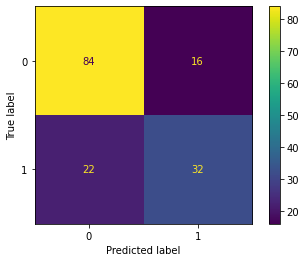

In [248]:
cm_ml = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_ml).plot();

In [249]:
# Ajuste de precisão/recall

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(log_clf, X_test_tr, y_test, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

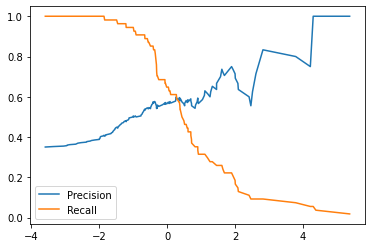

In [250]:
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.legend()
plt.show()

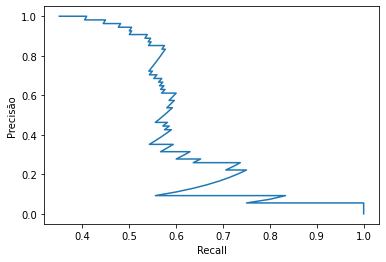

In [251]:
plt.plot(precisions, recalls)
plt.ylabel('Precisão')
plt.xlabel('Recall')
plt.show()

In [252]:
# Considerar drop de features: Insulin e SkinThickness
# Curva roc 
# Avaliar matriz de confusão e impacto financeiro do modelo